# 모델 구조 다이어그램
```
입력 레이어 (224x224x3)  
        │
        │
ResNet50 (최상위 레이어 제외, 사전 학습된 가중치 고정)
        │
        └─> Conv 레이어들 (1~140 레이어: 고정)
        │
        └─> Conv 레이어들 (141~끝 레이어: 학습 가능)
        └─> Pooling 레이어들
        └─> Residual 블록들
        │
        │
Global Average Pooling 레이어 (224x224x3 -> 2048)
        │
        │
완전 연결층 1 (512 유닛, ReLU 활성화 함수)
        │
        │
완전 연결층 2 (출력층, 5 유닛, 소프트맥스 활성화 함수)
        │
        │
출력 (5개의 클래스 확률)

```

# 라이브러리 가져오기

In [ ]:
import os
import shutil
import numpy as np
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Input, Add,Dropout, Dense, Activation, ZeroPadding2D, \
BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import  plot_model
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from IPython.display import SVG
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

# 데이터가져오고 train, test 데이터로 나누기

In [ ]:
# 모든 데이터셋이 있는 디렉토리
data_dir = '/content/drive/MyDrive/Dromii/resnet/input/flowers/'

# 학습 데이터 디렉토리
training_dir = '/content/drive/MyDrive/Dromii/resnet/working/Train'

# 테스트 데이터 디렉토리
testing_dir = '/content/drive/MyDrive/Dromii/resnet/working/Test'

# 학습 및 테스트 데이터 비율
train_test_ratio = 0.8


def split_dataset_into_test_and_train_sets(all_data_dir = data_dir, training_data_dir = training_dir, \
                                           testing_data_dir=testing_dir, train_test_ratio = 0.8):
    # 테스트 및 학습 디렉토리를 재생성
    if not os.path.exists(training_data_dir):
            os.mkdir(training_data_dir)

    if not os.path.exists(testing_data_dir):
            os.mkdir(testing_data_dir)

    # 학습 및 테스트 데이터 디렉토리가 존재하지 않으면 해당 디렉토리를 생성
    num_training_files = 0
    num_testing_files = 0

    # 학습 파일과 테스트 파일의 수를 세기 위해 두 개의 변수를 초기화
    for subdir, dirs, files in os.walk(all_data_dir):

        category_name = os.path.basename(subdir)

        # print(category_name + " vs " + os.path.basename(all_data_dir))
        if category_name == os.path.basename(all_data_dir):
              continue

        # os.walk 함수를 사용하여 모든 데이터 디렉토리를 순회
        # 각 하위 디렉토리(subdir)마다 해당 디렉토리의 이름을 추출하고, 상위 디렉토리의 이름과 같다면 다음 반복으로 넘어감
        training_data_category_dir = training_data_dir + '/' + category_name
        testing_data_category_dir = testing_data_dir + '/' + category_name

        # 각 카테고리에 대해 하위 디렉토리 생성
        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)

        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)

        # 각 카테고리에 대해 학습 및 테스트 데이터를 저장할 하위 디렉토리를 생성
        file_list = glob.glob(os.path.join(subdir,'*.jpg'))

        #print(os.path.join(all_data_dir, subdir))
        print(str(category_name) + ' has ' + str(len(files)) + ' images')
        random_set = np.random.permutation((file_list))

        # 각 카테고리에서 일정 비율만큼 데이터를 학습 및 테스트 디렉토리에 복사
        train_list = random_set[:round(len(random_set)*(train_test_ratio))]
        test_list = random_set[-round(len(random_set)*(1-train_test_ratio)):]

        for lists in train_list :
            shutil.copy(lists, training_data_dir + '/' + category_name + '/' )
            num_training_files += 1

        for lists in test_list :
            shutil.copy(lists, testing_data_dir + '/' + category_name + '/' )
            num_testing_files += 1


    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")

In [ ]:
split_dataset_into_test_and_train_sets()

rose has 784 images


KeyboardInterrupt: 

# ResNet50 전이학습



In [ ]:
# 데이터셋에 있는 클래스 수
num_classes = 5

def get_model():
    # 모델 정의 함수
    # 여기서는 ResNet50을 기본 모델로 사용
    base_model = ResNet50(weights='imagenet', include_top=False) # include_top=False : 최상위 fc layer 포함하지 않음,  ResNet50을 특징 추출 목적으로만 사용하고, 최종 분류는 내가 정의한 새로운 레이어를 통해 수행하기 위함

    # ResNet 모델을 특징 추출 목적으로만 사용하고 가중치를 조정하지 않기 위해
    # 기본 모델의 레이어를 고정합니다.
    for layer in base_model.layers:
        layer.trainable = False

    # 기본 모델의 출력 가져오기
    base_model_ouput = base_model.output

    # 새로운 레이어 추가하기
    x = GlobalAveragePooling2D()(base_model_ouput)
    # 완전 연결층 추가하기
    x = Dense(512, activation='relu')(x)
    x = Dense(num_classes, activation='softmax', name='fcnew')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

In [ ]:
# 모델 가져오기
model = get_model()
# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
# 모델 요약 출력
model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                         

# 데이터 전처리

In [ ]:
# 학습 및 테스트 이미지의 전처리를 위한 ImageDataGenerator 정의
# 검증 데이터 생성기에는 수평 반전이나 다른 전처리 작업을 적용하지 않음

image_size = 224
batch_size = 64

train_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
valid_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
train_generator = train_data_gen.flow_from_directory(training_dir, (image_size,image_size), batch_size=batch_size, class_mode='categorical')
valid_generator = valid_data_gen.flow_from_directory(testing_dir, (image_size,image_size), batch_size=batch_size, class_mode='categorical')

Found 3453 images belonging to 5 classes.
Found 864 images belonging to 5 classes.


---------------------------------------------------------------

In [ ]:
# 초기 에포크 동안 완전 연결 레이어 학습
epochs = 5

# 모델 학습
model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.n//batch_size,
    epochs=epochs,
    verbose=1)

Epoch 1/5
53/53 [==============================] - 2262s 43s/step - loss: 0.7181 - accuracy: 0.7448 - val_loss: 0.4541 - val_accuracy: 0.8425
Epoch 2/5
53/53 [==============================] - 72s 1s/step - loss: 0.4164 - accuracy: 0.8578 - val_loss: 0.3680 - val_accuracy: 0.8750
Epoch 3/5
53/53 [==============================] - 71s 1s/step - loss: 0.3400 - accuracy: 0.8905 - val_loss: 0.3484 - val_accuracy: 0.8702
Epoch 4/5
53/53 [==============================] - 68s 1s/step - loss: 0.3126 - accuracy: 0.8955 - val_loss: 0.3093 - val_accuracy: 0.8894
Epoch 5/5
53/53 [==============================] - 66s 1s/step - loss: 0.2760 - accuracy: 0.9121 - val_loss: 0.3200 - val_accuracy: 0.8918


In [ ]:
model_path = '/content/drive/MyDrive/Dromii/resnet/model'
file_name = 'ResNet50_5.keras'
full_path = os.path.join(model_path, file_name)
model.save(full_path)

# 파인튜닝 전이학습 모델

In [ ]:
# 모델 세밀 조정
# 150개 레이어 이후의 레이어를 학습시킴
# 일반적으로 ResNet은 하위 수준의 특징을 잘 추출하므로 초기 레이어는 조정하지 않음
epochs = 10

split_at = 140
for layer in model.layers[:split_at]: layer.trainable = False
for layer in model.layers[split_at:]: layer.trainable = True

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# 세밀한 조정을 위해 더 낮은 학습률 선택
# 초기 레이어를 세밀하게 조정할 때 학습률은 일반적으로 10~1000배 더 낮게 설정
from tensorflow.keras.optimizers.legacy import SGD

sgd = SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.n//batch_size,
    epochs=epochs,
    verbose=1)

Epoch 1/10
53/53 [==============================] - 79s 1s/step - loss: 0.3617 - accuracy: 0.8837 - val_loss: 0.3020 - val_accuracy: 0.8954
Epoch 2/10
53/53 [==============================] - 71s 1s/step - loss: 0.2356 - accuracy: 0.9292 - val_loss: 0.2558 - val_accuracy: 0.9062
Epoch 3/10
53/53 [==============================] - 76s 1s/step - loss: 0.1777 - accuracy: 0.9457 - val_loss: 0.2474 - val_accuracy: 0.9111
Epoch 4/10
53/53 [==============================] - 68s 1s/step - loss: 0.1444 - accuracy: 0.9572 - val_loss: 0.2310 - val_accuracy: 0.9171
Epoch 5/10
53/53 [==============================] - 68s 1s/step - loss: 0.1209 - accuracy: 0.9687 - val_loss: 0.2234 - val_accuracy: 0.9207
Epoch 6/10
53/53 [==============================] - 73s 1s/step - loss: 0.0911 - accuracy: 0.9764 - val_loss: 0.2311 - val_accuracy: 0.9159
Epoch 7/10
53/53 [==============================] - 75s 1s/step - loss: 0.0759 - accuracy: 0.9814 - val_loss: 0.2250 - val_accuracy: 0.9255
Epoch 8/10
53/53 [==

In [ ]:
model_path = '/content/drive/MyDrive/Dromii/resnet/model'
file_name = 'ResNet50_10.keras'
full_path = os.path.join(model_path, file_name)
model.save(full_path)

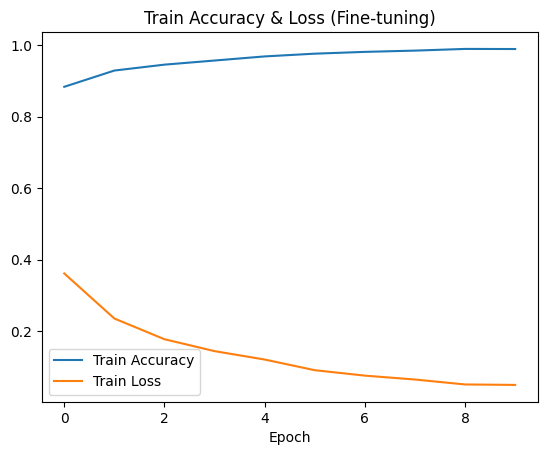

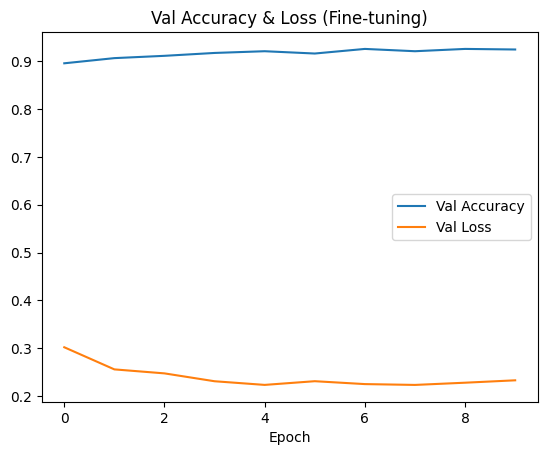

In [ ]:
# 학습 정확도 및 손실 시각화
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.title('Train Accuracy & Loss (Fine-tuning)')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

# 검증 정확도 및 손실 시각화
plt.plot(history_finetune.history['val_accuracy'], label='Val Accuracy')
plt.plot(history_finetune.history['val_loss'], label='Val Loss')
plt.title('Val Accuracy & Loss (Fine-tuning)')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

# 최종 성능 평가

Found 864 images belonging to 5 classes.
27/27 [==============================] - 5s 182ms/step - loss: 2.0973 - accuracy: 0.1771
Test Loss: 2.0973, Test Accuracy: 0.1771
27/27 [==============================] - 5s 201ms/step
Test Accuracy: 0.1771


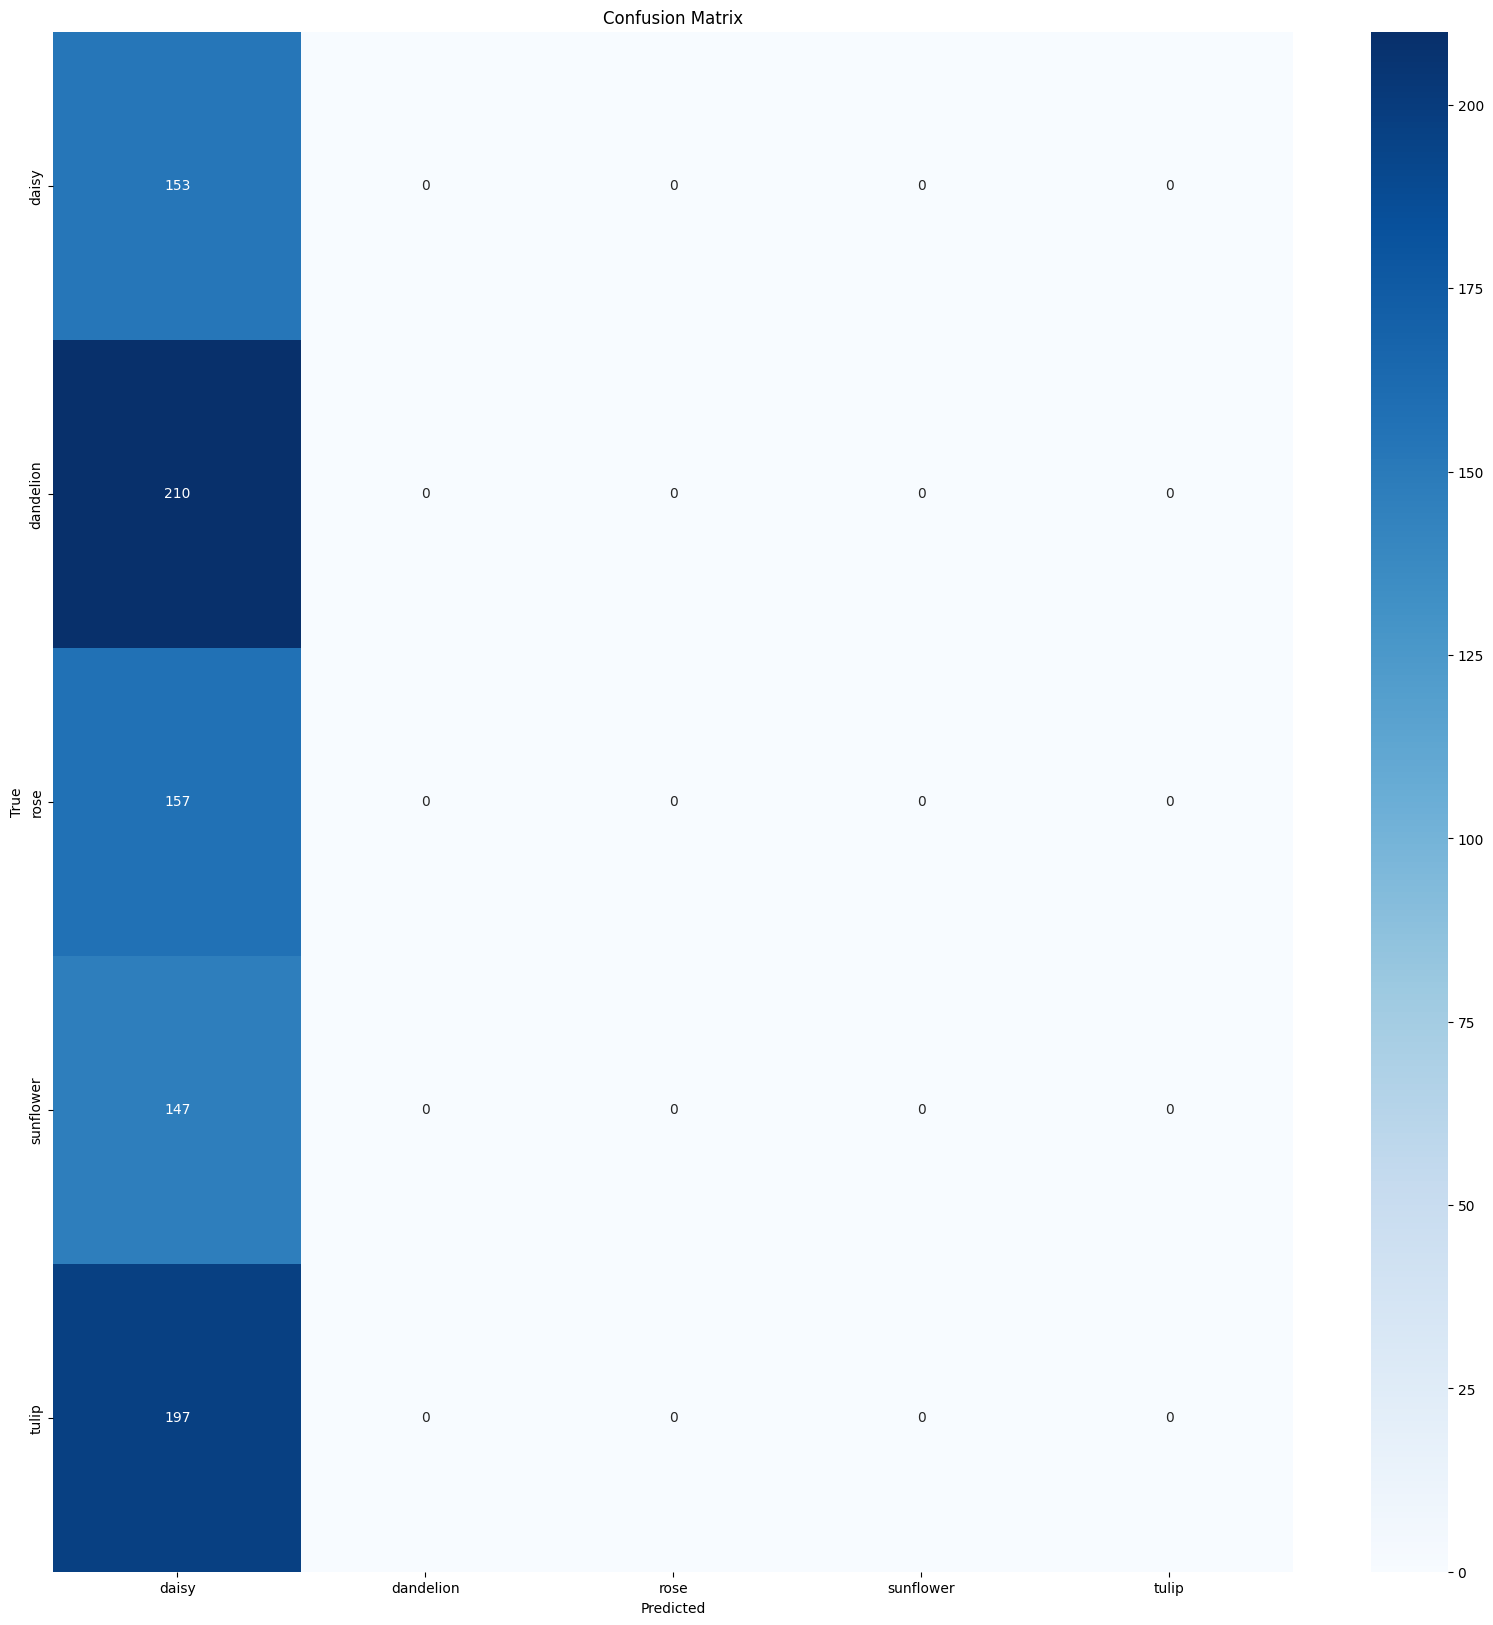

Classification Report
              precision    recall  f1-score   support

       daisy       0.18      1.00      0.30       153
   dandelion       0.00      0.00      0.00       210
        rose       0.00      0.00      0.00       157
   sunflower       0.00      0.00      0.00       147
       tulip       0.00      0.00      0.00       197

    accuracy                           0.18       864
   macro avg       0.04      0.20      0.06       864
weighted avg       0.03      0.18      0.05       864



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


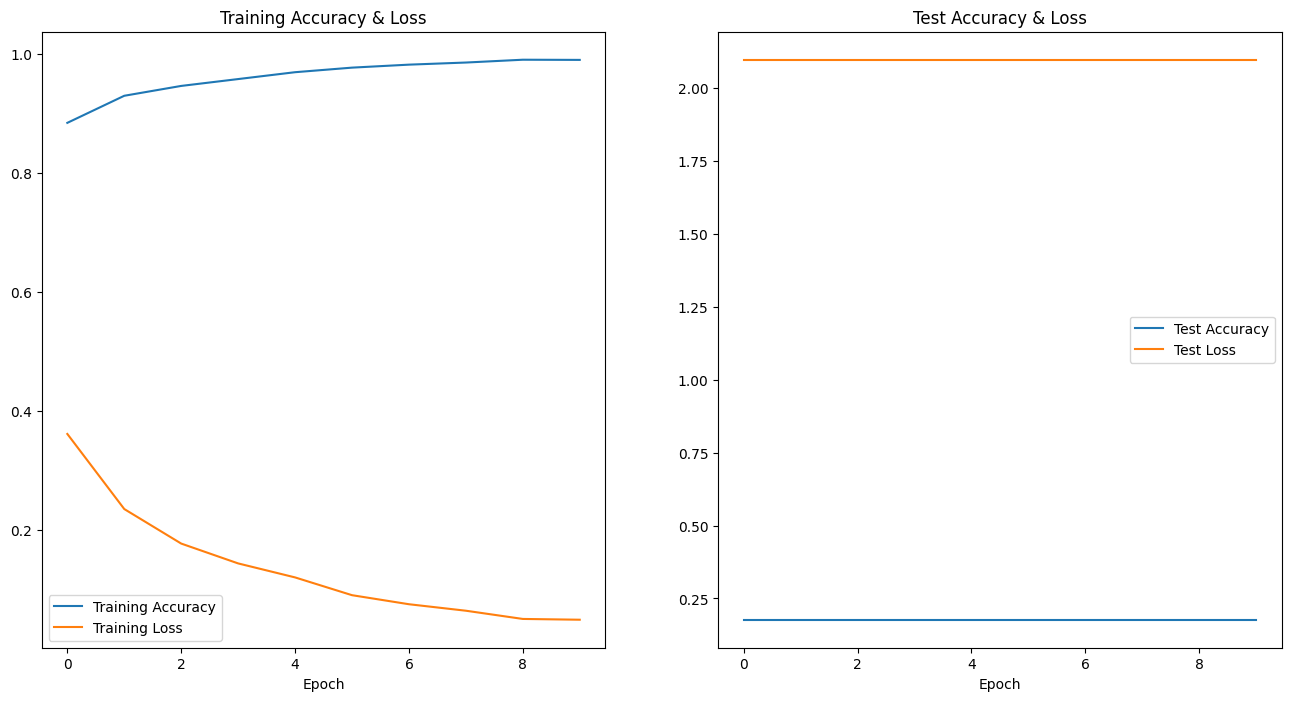

In [ ]:
# 테스트 데이터 경로 설정
test_path = "/content/drive/MyDrive/Dromii/resnet/working/Test"

# 데이터 전처리 및 증강 (테스트 데이터는 증강 없이 전처리만 함)
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# 최종 성능 평가를 위한 테스트 데이터셋 사용
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# 테스트 데이터셋에 대한 예측 수행
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# 정확도 계산
acc = accuracy_score(y_true, y_pred_classes)
print(f'Test Accuracy: {acc:.4f}')

# 혼동 행렬 계산
cm = confusion_matrix(y_true, y_pred_classes)
cm_plot_labels = list(test_generator.class_indices.keys())

# 혼동 행렬 시각화
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_plot_labels, yticklabels=cm_plot_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 분류 보고서 출력
print('Classification Report')
print(classification_report(y_true, y_pred_classes, target_names=cm_plot_labels))

# 테스트 정확도 및 손실 시각화
epochs_range = range(len(history_finetune.history['accuracy']))
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_finetune.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history_finetune.history['loss'], label='Training Loss')
plt.title('Training Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, [test_accuracy]*len(epochs_range), label='Test Accuracy')
plt.plot(epochs_range, [test_loss]*len(epochs_range), label='Test Loss')
plt.title('Test Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.show()

## 최종 성능 평가 - 분석

1. Confusion Matrix (혼동 행렬):
* 각 클래스에 대해 모델이 얼마나 잘 분류했는지 시각적으로 보여준다.
* 현재 혼동 행렬에서는 모든 클래스에 대해 모델이 "daisy"로 분류한 것을 볼 수 있다.
* 이는 모델이 다른 클래스들을 제대로 인식하지 못하고 하나의 클래스("daisy")에만 편향되었음을 나타낸다.

2. Training and Test Accuracy & Loss:
* 학습 데이터셋에서는 높은 정확도와 낮은 손실을 보이지만, 테스트 데이터셋에서는 매우 낮은 정확도와 높은 손실을 보인다.
* 이는 모델이 학습 데이터에 과적합되었고, 일반화가 제대로 되지 않았음을 시사한다.

3. Classification Report:
* 각 클래스별 Precision, Recall, F1-score을 보여준다.
* 모델이 "daisy" 클래스에서만 높은 Recall을 보이며, 다른 클래스에서는 모두 0으로 나타난다.
* 전체 정확도는 18%로, 이는 모델이 대부분의 클래스에서 제대로 분류하지 못하고 있음을 나타낸다.


## 최종 성능 평가 - 개선 방안
1. 정규화 기법 사용:
* 드롭아웃(Dropout) 또는 L2 정규화와 같은 정규화 기법을 사용하여 과적합 방지.

\
2. 데이터 증강 (Data Augmentation):
* 학습 데이터에 다양한 변형을 적용하여 모델이 더 일반적인 패턴을 학습할 수 있도록 함.

\
3. 하이퍼파라미터 튜닝:
* 학습률, 배치 크기, 에포크 수 등 하이퍼파라미터를 조정하여 모델 성능 최적화.

\
4. 데이터셋 검토 및 전처리:
* 학습 데이터와 테스트 데이터의 전처리 방식이 일관되게 적용되었는지 확인.
* 데이터셋의 분포를 검토하고, 불균형이 있을 경우 이를 조정.